<a href="https://colab.research.google.com/github/AkashKK25/pneumonia-xray-detection/blob/main/notebooks/pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection from Chest X-Rays
#### Author: Akash

## Setup and Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Step 2: Download and prepare the dataset

In [1]:
# Install Kaggle API
!pip install kaggle

# Upload your Kaggle API credentials
from google.colab import files
files.upload()  # Upload kaggle.json file

# Make the Kaggle directory
!mkdir -p ~/.kaggle

# Copy the kaggle.json file
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Step 3: Explore the dataset

Training set: 1341 normal, 3875 pneumonia
Validation set: 8 normal, 8 pneumonia
Test set: 234 normal, 390 pneumonia


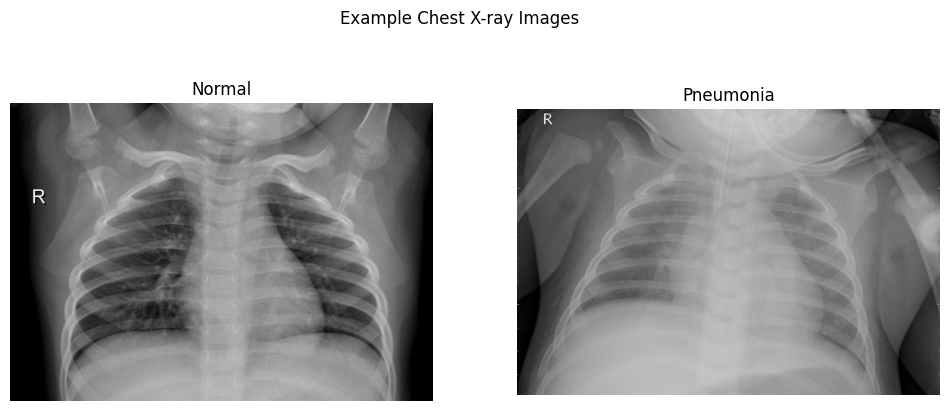

In [3]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Check if the val directory exists - if not, create it from train
if not os.path.exists(val_dir) or len(os.listdir(os.path.join(val_dir, 'NORMAL'))) == 0:
    print("Validation directory is empty or doesn't exist. Creating validation set from training data...")

    # Create val directory if it doesn't exist
    os.makedirs(os.path.join(val_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'PNEUMONIA'), exist_ok=True)

    # Move 10% of training data to validation
    import random
    import shutil

    for cls in ['NORMAL', 'PNEUMONIA']:
        src_dir = os.path.join(train_dir, cls)
        files = os.listdir(src_dir)
        num_val = int(len(files) * 0.1)  # 10% for validation
        val_files = random.sample(files, num_val)

        for file in val_files:
            src_path = os.path.join(src_dir, file)
            dst_path = os.path.join(val_dir, cls, file)
            shutil.move(src_path, dst_path)

    print("Validation set created.")

# Count the number of images in each split
def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal_count, pneumonia_count

train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)

print(f"Training set: {train_normal} normal, {train_pneumonia} pneumonia")
print(f"Validation set: {val_normal} normal, {val_pneumonia} pneumonia")
print(f"Test set: {test_normal} normal, {test_pneumonia} pneumonia")

# Visualize some example images
plt.figure(figsize=(12, 5))

# Normal example
normal_img_path = os.path.join(train_dir, 'NORMAL', os.listdir(os.path.join(train_dir, 'NORMAL'))[0])
normal_img = Image.open(normal_img_path)
plt.subplot(1, 2, 1)
plt.imshow(normal_img, cmap='gray')
plt.title('Normal')
plt.axis('off')

# Pneumonia example
pneumonia_img_path = os.path.join(train_dir, 'PNEUMONIA', os.listdir(os.path.join(train_dir, 'PNEUMONIA'))[0])
pneumonia_img = Image.open(pneumonia_img_path)
plt.subplot(1, 2, 2)
plt.imshow(pneumonia_img, cmap='gray')
plt.title('Pneumonia')
plt.axis('off')

plt.suptitle('Example Chest X-ray Images')
plt.show()

# Step 4: Data Preprocessing and Augmentation

In [4]:
IMG_SIZE = 224  # MobileNetV2 input size

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Step 5: Create the Model using Transfer Learning

In [5]:
# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Step 6: Train the model

In [6]:
# Set up callbacks for better training
checkpoint = ModelCheckpoint(
    'pneumonia_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.7332 - loss: 0.5202
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 959ms/step - accuracy: 0.7339 - loss: 0.5191 - val_accuracy: 0.8125 - val_loss: 0.3597 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9403 - loss: 0.1680
Epoch 2: val_accuracy improved from 0.81250 to 0.87500, saving model to pneumonia_model_best.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.9403 - loss: 0.1680 - val_accuracy: 0.8750 - val_loss: 0.2985 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9476 - loss: 0.1431
Epoch 3: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 578ms/step - accuracy: 0.9476 - loss: 0.1431 - val_accuracy: 0.8750 - val_loss: 0.2665 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9530 - loss: 0.1298
Epoch 4: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 583ms/step - accuracy: 0.9529 - loss: 0.1298 - val_accuracy: 0.8750 - val_loss: 0.2571 - learning_rate: 1.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9584 - loss: 0.1140
Epoch 5: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.9584 - loss: 0.1140 - val_accuracy: 0.8750 - val_loss: 0.2896 - learning_rate: 

# Step 7: Train the top layers, then fine-tune a few convolutional layers

In [7]:
# Unfreeze the top layers of the model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train again with fine-tuning
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9120 - loss: 0.2406
Epoch 1: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 605ms/step - accuracy: 0.9121 - loss: 0.2404 - val_accuracy: 0.6250 - val_loss: 0.8579 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9508 - loss: 0.1385
Epoch 2: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 591ms/step - accuracy: 0.9508 - loss: 0.1385 - val_accuracy: 0.5625 - val_loss: 1.3958 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9549 - loss: 0.1149
Epoch 3: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 590ms/step - accuracy: 0.9549 - loss: 0.1149 - val_accuracy: 0.5625 - val_loss: 1.3003 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9611 - loss: 0.1064
Epoch 4: val_accuracy did not improve from 0.87500

# Step 8: Evaluate the model

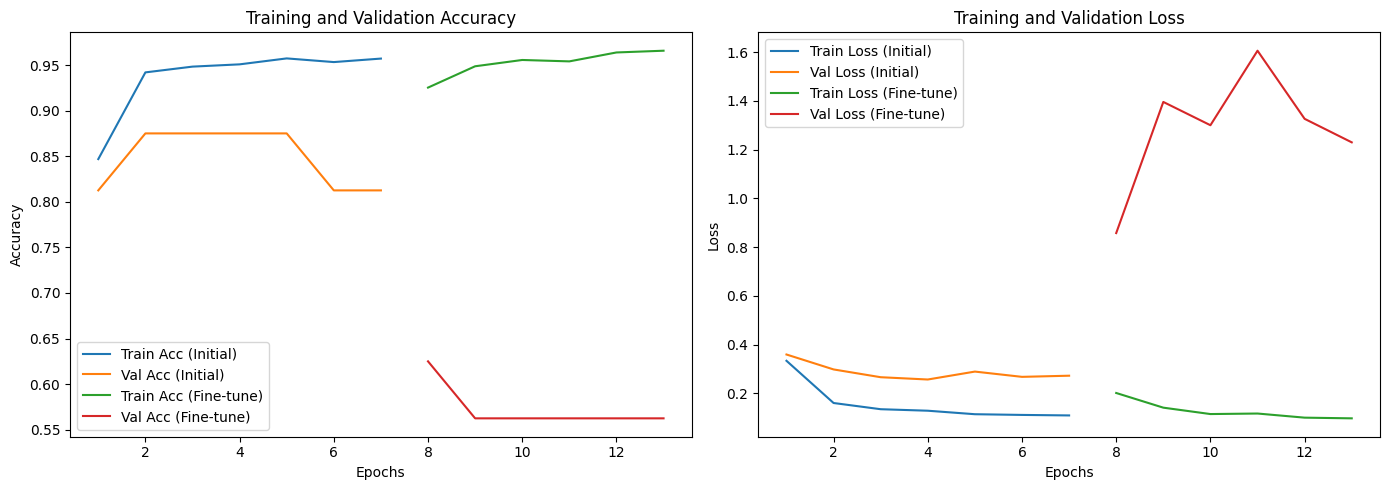

In [8]:
# Combine the history objects
total_epochs = len(history.history['accuracy']) + len(history_fine_tune.history['accuracy'])
epochs_range = range(1, total_epochs + 1)

plt.figure(figsize=(14, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(
    epochs_range[:len(history.history['accuracy'])],
    history.history['accuracy'],
    label='Train Acc (Initial)'
)
plt.plot(
    epochs_range[:len(history.history['val_accuracy'])],
    history.history['val_accuracy'],
    label='Val Acc (Initial)'
)
plt.plot(
    epochs_range[len(history.history['accuracy']):],
    history_fine_tune.history['accuracy'],
    label='Train Acc (Fine-tune)'
)
plt.plot(
    epochs_range[len(history.history['val_accuracy']):],
    history_fine_tune.history['val_accuracy'],
    label='Val Acc (Fine-tune)'
)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(
    epochs_range[:len(history.history['loss'])],
    history.history['loss'],
    label='Train Loss (Initial)'
)
plt.plot(
    epochs_range[:len(history.history['val_loss'])],
    history.history['val_loss'],
    label='Val Loss (Initial)'
)
plt.plot(
    epochs_range[len(history.history['loss']):],
    history_fine_tune.history['loss'],
    label='Train Loss (Fine-tune)'
)
plt.plot(
    epochs_range[len(history.history['val_loss']):],
    history_fine_tune.history['val_loss'],
    label='Val Loss (Fine-tune)'
)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 9: Test set evaluation

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.6050 - loss: 1.0383
Test Accuracy: 0.7821
Test Loss: 0.5994
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step


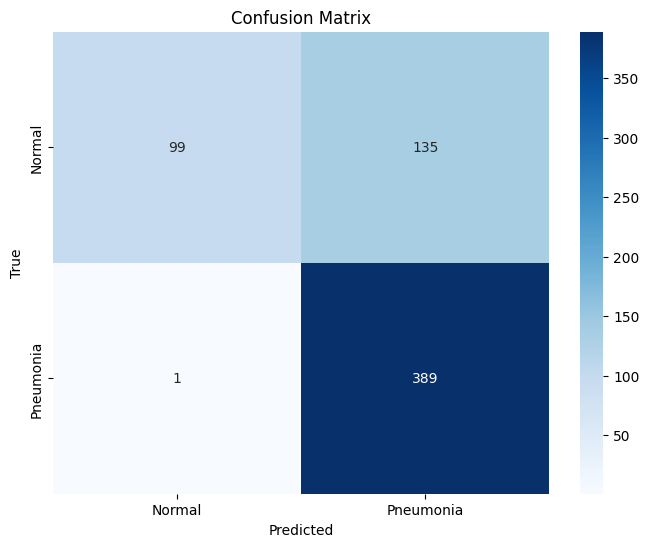

              precision    recall  f1-score   support

      Normal       0.99      0.42      0.59       234
   Pneumonia       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.87      0.71      0.72       624
weighted avg       0.84      0.78      0.75       624



In [9]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions for test data
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = test_generator.classes

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = ['Normal', 'Pneumonia']
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Step 10: Save the model for deployment

In [10]:
model.save('pneumonia_model_final.h5')

# Convert to TensorFlow Lite for deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model
with open('pneumonia_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite format for deployment.")

Saved artifact at '/tmp/tmp7wrn_dlu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133007286414096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286414672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286418128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286417744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286416592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286418320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286417360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286414288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286418512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133007286416400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13300728641755

# Step 11: Visualize model predictions on test images

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


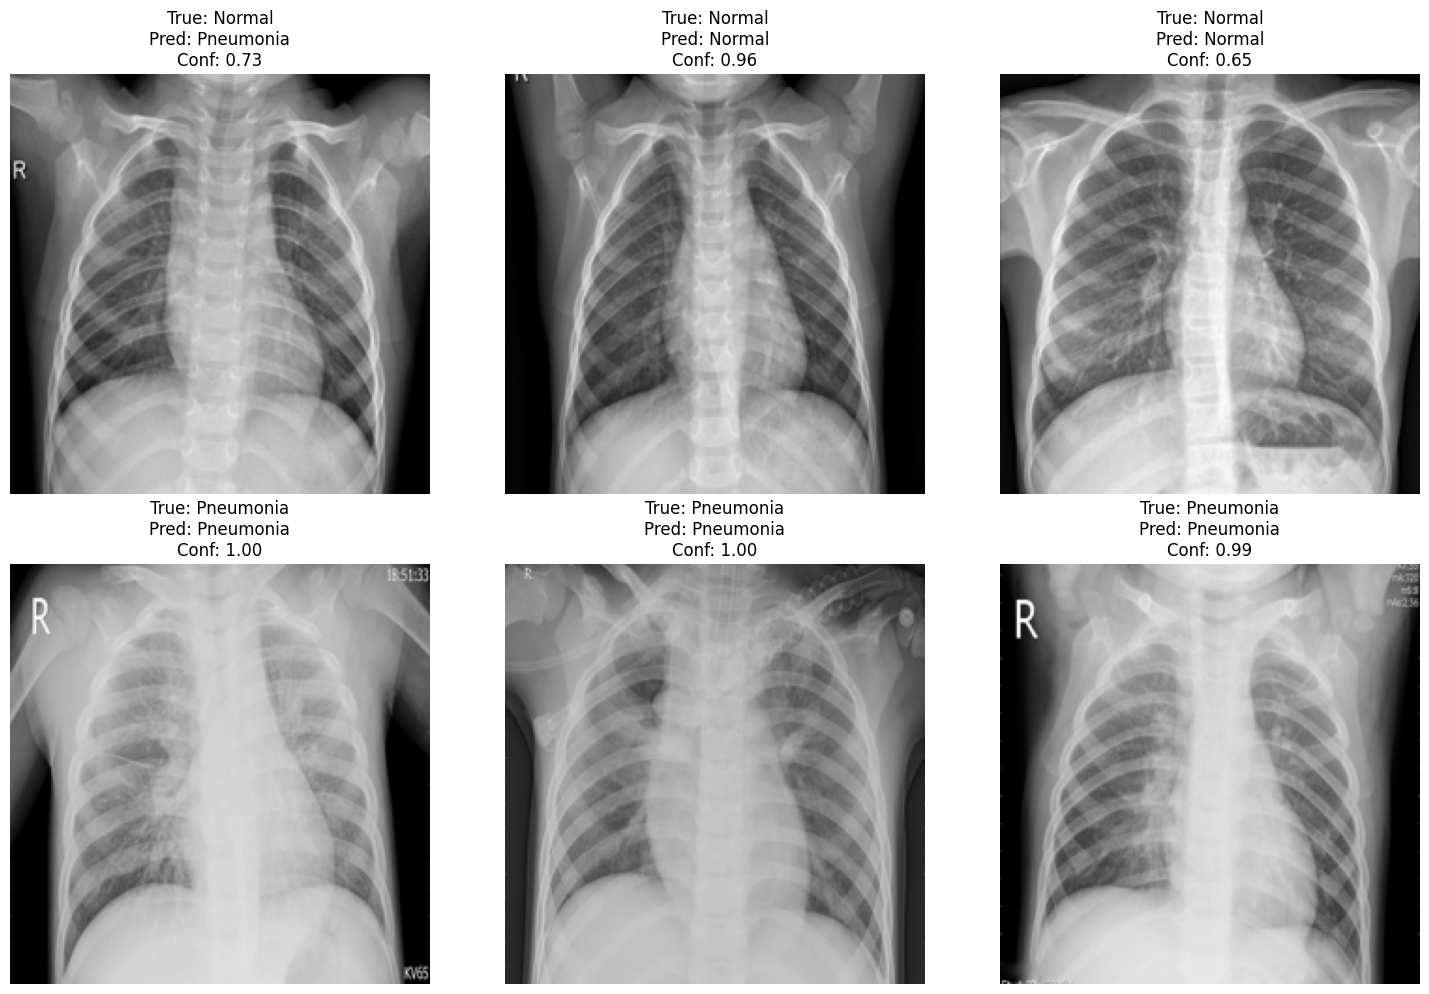

In [11]:
def display_predictions(model, test_dir, num_samples=6):
    # Get random images from test set
    normal_files = os.listdir(os.path.join(test_dir, 'NORMAL'))
    pneumonia_files = os.listdir(os.path.join(test_dir, 'PNEUMONIA'))

    # Randomly select images from each class
    normal_samples = np.random.choice(normal_files, min(num_samples//2, len(normal_files)), replace=False)
    pneumonia_samples = np.random.choice(pneumonia_files, min(num_samples//2, len(pneumonia_files)), replace=False)

    plt.figure(figsize=(15, 10))
    count = 1

    # Process normal images
    for sample in normal_samples:
        img_path = os.path.join(test_dir, 'NORMAL', sample)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        predicted_class = "Pneumonia" if prediction > 0.5 else "Normal"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.subplot(2, num_samples//2, count)
        plt.imshow(img)
        plt.title(f"True: Normal\nPred: {predicted_class}\nConf: {confidence:.2f}")
        plt.axis('off')
        count += 1

    # Process pneumonia images
    for sample in pneumonia_samples:
        img_path = os.path.join(test_dir, 'PNEUMONIA', sample)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)[0][0]
        predicted_class = "Pneumonia" if prediction > 0.5 else "Normal"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.subplot(2, num_samples//2, count)
        plt.imshow(img)
        plt.title(f"True: Pneumonia\nPred: {predicted_class}\nConf: {confidence:.2f}")
        plt.axis('off')
        count += 1

    plt.tight_layout()
    plt.show()

# Display model predictions on sample test images
display_predictions(model, test_dir)

# Step 12: Download the models

In [12]:
from google.colab import files
files.download('pneumonia_model_final.h5')
files.download('pneumonia_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>